# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Working with Spectrograms

In [2]:
data_path = 'data/stock_technical_data/'

In [3]:
df = pd.read_csv(data_path + 'AUBANK.NS.csv', index_col=0)

In [4]:
sample_data = df['Close'].values
print(len(sample_data))

1322


In [5]:
reduced_data = sample_data[:25]

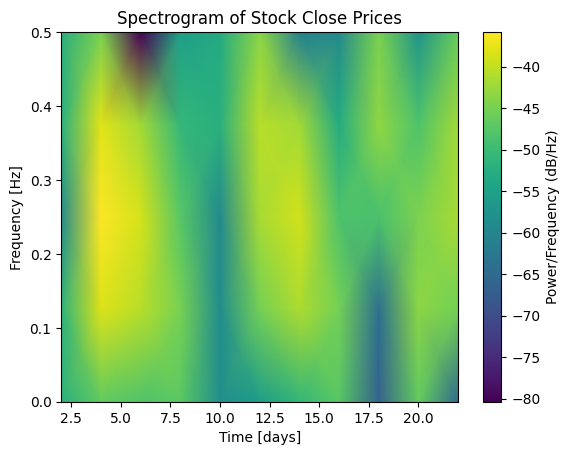

In [6]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(reduced_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=2, nfft=8, detrend='constant', scaling='density', mode='psd')

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [days]')
plt.title('Spectrogram of Stock Close Prices')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

# Setting up the Prediction Models

In [7]:
def generate_spectrogram(window_data):
    frequencies, times, Sxx = spectrogram(window_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=2, nfft=8, detrend='constant', scaling='density', mode='psd')
    return frequencies, times, Sxx

1000


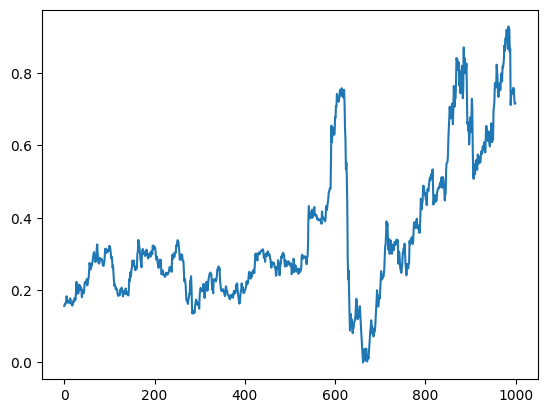

In [8]:
noofdays = 25

close_prices = df['Close'].values
close_prices = close_prices[0:1000]
print(len(close_prices))

# plot the close prices
plt.plot(close_prices)

In [37]:
X = []
y = []

for i in range(len(close_prices) - noofdays):
    window_data = close_prices[i:i + noofdays]
    spectrogram_data = generate_spectrogram(window_data)
    X.append(spectrogram_data[2])
    # Label: 1 if price on day 26 is greater than day 25, else 0
    label = 1 if close_prices[i + noofdays] > close_prices[i + noofdays - 1] else 0
    y.append(label)

In [38]:
print(len(X))
print(len(y))

975
975


In [39]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(975, 5, 11)
(975,)


In [40]:
# Reshape X to add a channel dimension (batch_size, 1, 5, 11)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

# Convert X and y to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [41]:
# Create a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [42]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self._to_linear = None
        self._get_conv_output_size()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 2)

    def _get_conv_output_size(self):
        x = torch.randn(1, 1, 5, 11)  
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        self._to_linear = x.numel()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self._to_linear)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [43]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
losses = []

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for inputs, labels in dataloader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    epoch_accuracy = total_correct / total_samples
    losses.append(avg_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print("Training complete.")


Epoch [1/20], Loss: 0.7321, Accuracy: 0.4851
Epoch [2/20], Loss: 0.7009, Accuracy: 0.4708
Epoch [3/20], Loss: 0.7020, Accuracy: 0.4913
Epoch [4/20], Loss: 0.6908, Accuracy: 0.5005
Epoch [5/20], Loss: 0.6904, Accuracy: 0.5251
Epoch [6/20], Loss: 0.6906, Accuracy: 0.5005
Epoch [7/20], Loss: 0.6862, Accuracy: 0.5374
Epoch [8/20], Loss: 0.6926, Accuracy: 0.5559
Epoch [9/20], Loss: 0.6898, Accuracy: 0.5467
Epoch [10/20], Loss: 0.6861, Accuracy: 0.5210
Epoch [11/20], Loss: 0.6883, Accuracy: 0.5200
Epoch [12/20], Loss: 0.6837, Accuracy: 0.5538
Epoch [13/20], Loss: 0.6838, Accuracy: 0.5210
Epoch [14/20], Loss: 0.6841, Accuracy: 0.5436
Epoch [15/20], Loss: 0.6868, Accuracy: 0.5272
Epoch [16/20], Loss: 0.6833, Accuracy: 0.5426
Epoch [17/20], Loss: 0.6756, Accuracy: 0.5692
Epoch [18/20], Loss: 0.6805, Accuracy: 0.5467
Epoch [19/20], Loss: 0.6754, Accuracy: 0.5631
Epoch [20/20], Loss: 0.6737, Accuracy: 0.5713
Training complete.
